# Full waveform inversion by model extension (FWIME) - Salt Model

---
* Authors: Guillaume Barnier (barnier@gmail.com), Ettore Biondi (ebiondi@caltech.edu), and Stuart Farris (sfarris@sep.stanford.edu)
* Date: 05/12/2022
* Feel free to contact us for any questions

---
# I. Description
This Jupyter notebook allows you to reproduce the results published in Barnier et al. (2022) using a modified model from the BP benchmark (Billette and Brandsberg-Dahl, 2004). The notebook is organized with the following steps:
* Build velocity models
* Generate mask for gradient
* Conventional data-space mutli-scale FWI
* FWIME
* Results analysis
* References

# II. Setup

## Import modules and libraries

In [1]:
# Import libraries
import genericIO
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
from scipy.ndimage import gaussian_filter
from matplotlib import pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
params = {
    'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 300,  # to adjust notebook inline plot size
    'axes.labelsize': 14, # fontsize for x and y labels (was 10)
    'axes.titlesize': 14,
    'font.size': 14, 
    'legend.fontsize': 12,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14
}
matplotlib.rcParams.update(params)

# Set the path for the executables
%env ACO_GPU_PACK=/opt/acoustic_2d/local/

# Set the path where the binaries will be written on disk
# %env DATAPATH=/net/vision/scr2/gbarnier/
%env LD_LIBRARY_PATH=/opt/acoustic_2d/local/lib/:/opt/elastic_2d/local/lib/:$LD_LIBRARY_PATH
%env PYTHONPATH=/opt/acoustic_2d/local/lib/python3.7:/opt/elastic_2d/local/lib/python3.7:$PYTHONPATH

env: ACO_GPU_PACK=/opt/acoustic_2d/local/
env: DATAPATH=/net/vision/scr2/gbarnier/


## Velocity models

In [2]:
# Read velocity models
vel_true = genericIO.defaultIO.getVector("vel/BP_Salt-trueVel.H")
vel_init = genericIO.defaultIO.getVector("vel/BP_Salt-initVel1.H")

# Get numpy array + hypecube info
vel_true_nd = vel_true.getNdArray()
vel_init_nd = vel_init.getNdArray()
vel_hyper = vel_true.getHyper()

# Get axes information
oz = vel_hyper.getAxis(1).o
dz = vel_hyper.getAxis(1).d
nz = vel_hyper.getAxis(1).n
ox = vel_hyper.getAxis(2).o
dx = vel_hyper.getAxis(2).d
nx = vel_hyper.getAxis(2).n

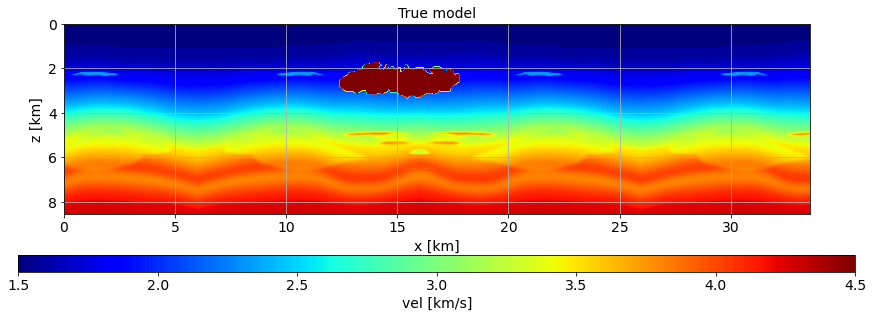

In [3]:
# Plot true velocity model
plt.figure(figsize=(15,5))
plt.imshow(vel_true_nd.T,cmap='jet', vmin=vel_true_nd.min(), vmax=vel_true_nd.max(), extent=(ox, (ox+(nx-1)*dx), (oz+(nz-1)*dz), oz), aspect="equal")
plt.title("True model"), plt.xlabel("x [km]"), plt.ylabel("z [km]")
plt.colorbar(orientation="horizontal", label="vel [km/s]", aspect=50)
plt.grid()
plt.show()

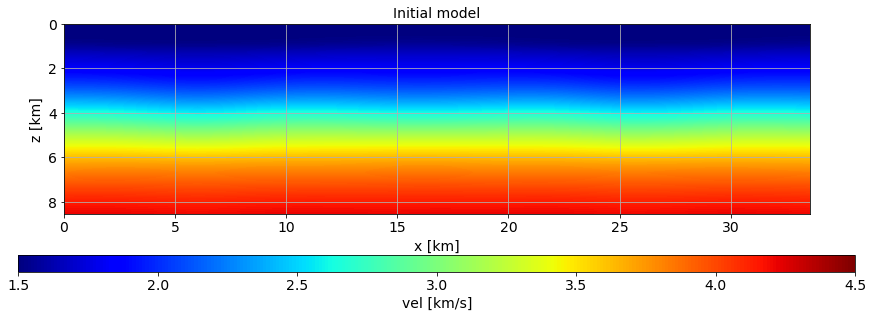

In [4]:
# Plot initial velocity model
plt.figure(figsize=(15,5))
plt.imshow(vel_init_nd.T,cmap='jet', vmin=1.5, vmax=4.5, extent=(ox, (ox+(nx-1)*dx), (oz+(nz-1)*dz), oz),aspect="equal")
plt.title("Initial model"), plt.xlabel("x [km]"), plt.ylabel("z [km]")
plt.colorbar(orientation="horizontal", label="vel [km/s]", aspect=50)
plt.grid()
plt.show()

## Pad velocity models
In this numerical example, we use absorbing boundaries in all directions

In [6]:
%%bash

# Pad both initial and true velocity models
${ACO_GPU_PACK}/bin/padFileGpuMain zPad=50 xPad=50 model=vel/BP_Salt-trueVel.H data=vel/BP_Salt-trueVel.pad.H &&\
${ACO_GPU_PACK}/bin/padFileGpuMain zPad=50 xPad=50 model=vel/BP_Salt-initVel1.H data=vel/BP_Salt-initVel1.pad.H

 
------------------------ Model padding program --------------------
Original nz = 215 [samples]
Original nx = 840 [samples]
 
zPadMinus = 50 [samples]
zPadPlus = 55 [samples]
xPadMinus = 50 [samples]
xPadPlus = 54 [samples]
 
blockSize = 16 [samples]
FAT = 5 [samples]
 
New nz = 330 [samples including padding and FAT]
New nx = 954 [samples including padding and FAT]
-------------------------------------------------------------------
 
 
------------------------ Model padding program --------------------
Original nz = 215 [samples]
Original nx = 840 [samples]
 
zPadMinus = 50 [samples]
zPadPlus = 55 [samples]
xPadMinus = 50 [samples]
xPadPlus = 54 [samples]
 
blockSize = 16 [samples]
FAT = 5 [samples]
 
New nz = 330 [samples including padding and FAT]
New nx = 954 [samples including padding and FAT]
-------------------------------------------------------------------
 


## Mask for gradient
* We generate different masks for the inversions on the different spline grids. 
* The same way we would create different masks for conventional data-space multi-scale FWI
* The mask only restrains the inversion from updating the water layer
* The "finer" the grid, the sharper the mask is in the vicinity of the water bottom

In [7]:
%%bash

################# Mask for spline 1 #################
# Create mask for gradient to prevent updates in the water layer
Vel n1=215 n2=840 n3=1 d1=1 d2=1 d3=1 o1=0.0 o2=0.0 o3=0.0 vc=1 > temp2.H &&\
echo "d1=0.04 d2=0.04 d3=0.04" >> temp2.H &&\
${ACO_GPU_PACK}/bin/padFileGpuMain zPad=50 xPad=50 model=temp2.H data=temp2.pad.H &&\
# Create mask
${ACO_GPU_PACK}/bin/maskGradientMain.py bufferUp=0.2 bufferDown=0.2 taperExp=2 wbShift=0.3 vel=vel/BP_Salt-trueVel.pad.H model=temp2.pad.H data=temp3.H mask=tempMask1.H &&\
Window3d n1=215 f1=55 n2=840 f2=55 < tempMask1.H > tempMask2.H &&\
Smooth rect2=2 < tempMask2.H > tempMask3.H &&\
${ACO_GPU_PACK}/bin/padFileGpuMain zPad=50 xPad=50 model=tempMask3.H data=vel/BP_Salt-gradMask1.pad.H &&\

################# Mask for spline 2 #################
Vel n1=215 n2=840 n3=1 d1=1 d2=1 d3=1 o1=0.0 o2=0.0 o3=0.0 vc=1 > temp2.H &&\
echo "d1=0.04 d2=0.04 d3=0.04" >> temp2.H &&\
${ACO_GPU_PACK}/bin/padFileGpuMain zPad=50 xPad=50 model=temp2.H data=temp2.pad.H &&\
# Create mask
${ACO_GPU_PACK}/bin/maskGradientMain.py bufferUp=0.2 bufferDown=0.2 taperExp=2 wbShift=0.0 vel=vel/BP_Salt-trueVel.pad.H model=temp2.pad.H data=temp3.H mask=tempMask1.H &&\
Window3d n1=215 f1=55 n2=840 f2=55 < tempMask1.H > tempMask2.H &&\
Smooth rect2=2 < tempMask2.H > tempMask3.H &&\
${ACO_GPU_PACK}/bin/padFileGpuMain zPad=50 xPad=50 model=tempMask3.H data=vel/BP_Salt-gradMask2.pad.H

 
------------------------ Model padding program --------------------
Original nz = 215 [samples]
Original nx = 840 [samples]
 
zPadMinus = 50 [samples]
zPadPlus = 55 [samples]
xPadMinus = 50 [samples]
xPadPlus = 54 [samples]
 
blockSize = 16 [samples]
FAT = 5 [samples]
 
New nz = 330 [samples including padding and FAT]
New nx = 954 [samples including padding and FAT]
-------------------------------------------------------------------
 
--- User has not provided a gradient mask file ---
--- Automatically generating the mask from the provided parameters ---
 
------------------------ Model padding program --------------------
Original nz = 215 [samples]
Original nx = 840 [samples]
 
zPadMinus = 50 [samples]
zPadPlus = 55 [samples]
xPadMinus = 50 [samples]
xPadPlus = 54 [samples]
 
blockSize = 16 [samples]
FAT = 5 [samples]
 
New nz = 330 [samples including padding and FAT]
New nx = 954 [samples including padding and FAT]
------------------------------------------------------------------

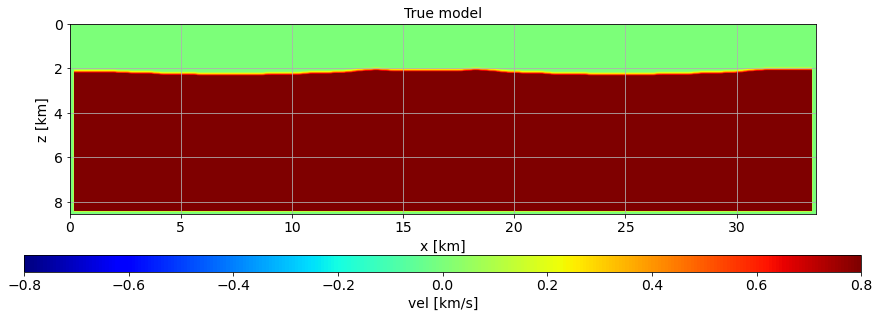

In [8]:
# Display mask
gradient_mask1 = genericIO.defaultIO.getVector("vel/BP_Salt-gradMask1.pad.H")
gradient_mask1_nd = gradient_mask1.getNdArray()
plt.figure(figsize=(15,5))
plt.imshow(gradient_mask1_nd.T,cmap='jet', vmin=-0.8, vmax=0.8, extent=(ox, (ox+(nx-1)*dx), (oz+(nz-1)*dz), oz), aspect="equal")
plt.title("True model"), plt.xlabel("x [km]"), plt.ylabel("z [km]")
plt.colorbar(orientation="horizontal", label="vel [km/s]", aspect=50)
plt.grid()
plt.show()

## Create dummy velocity model 
We create this dummy file to pass the model dimension and hypercube information to the FWIME script and to the spline operator 

In [9]:
%%bash

Cp vel/BP_Salt-trueVel.pad.H vel/BP_Salt_velDummy.pad.H

# III. Conventional data-space multi-scale FWI

## Create wavelets

For simplicity, we generate 5 wavelets and datasets corresponding to each frequency band instead of generating one dataset and bandpassing every time


In [11]:
%%bash

# Wavelet for FWI data-space multi-scale
# 2-3 Hz
${ACO_GPU_PACK}/bin/waveletFloatMain.py par=par/BP_Salt-fwi-2-9.p timeDelay=2.0 f1=1.5 f2=2.5 f3=2.5 f4=3.5 type=ali wavelet=wav/BP_Salt-fwi-wav-2-3.H &&\

# 2-4 Hz
${ACO_GPU_PACK}/bin/waveletFloatMain.py par=par/BP_Salt-fwi-2-9.p timeDelay=2.0 f1=1.5 f2=2.5 f3=3.0 f4=4.5 type=ali wavelet=wav/BP_Salt-fwi-wav-2-4.H &&\

# 2-5 Hz
${ACO_GPU_PACK}/bin/waveletFloatMain.py par=par/BP_Salt-fwi-2-9.p timeDelay=2.0 f1=1.5 f2=2.5 f3=4.0 f4=5.5 type=ali wavelet=wav/BP_Salt-fwi-wav-2-5.H &&\

# 2-7 Hz
${ACO_GPU_PACK}/bin/waveletFloatMain.py par=par/BP_Salt-fwi-2-9.p timeDelay=2.0 f1=1.5 f2=2.5 f3=5.0 f4=7.0 type=ali wavelet=wav/BP_Salt-fwi-wav-2-7.H &&\

# 2-9 Hz
${ACO_GPU_PACK}/bin/waveletFloatMain.py par=par/BP_Salt-fwi-2-9.p timeDelay=2.0 f1=1.5 f2=2.5 f3=7.0 f4=9.0 type=ali wavelet=wav/BP_Salt-fwi-wav-2-9.H



## Display wavelets time series

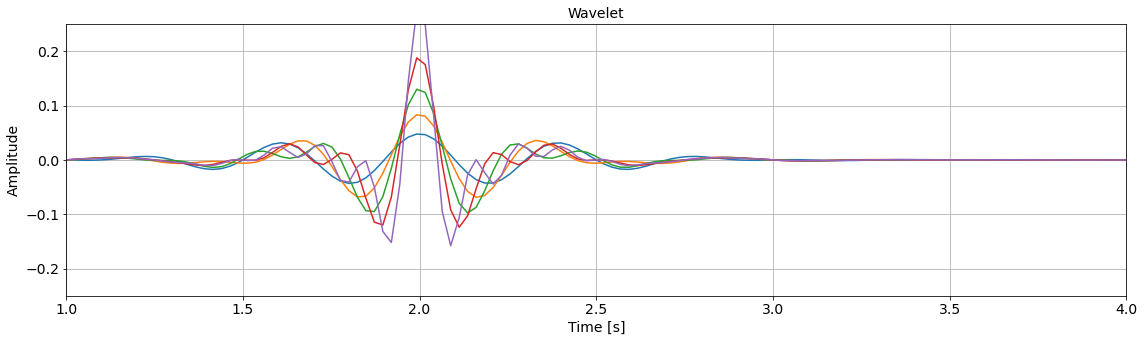

In [13]:
# Read wavelets 
wav_2_3 = genericIO.defaultIO.getVector("wav/BP_Salt-fwi-wav-2-3.H")
wav_2_4 = genericIO.defaultIO.getVector("wav/BP_Salt-fwi-wav-2-4.H")
wav_2_5 = genericIO.defaultIO.getVector("wav/BP_Salt-fwi-wav-2-5.H")
wav_2_7 = genericIO.defaultIO.getVector("wav/BP_Salt-fwi-wav-2-7.H")
wav_2_9 = genericIO.defaultIO.getVector("wav/BP_Salt-fwi-wav-2-9.H")

# Get numpy arrays
wav_2_3_nd = wav_2_3.getNdArray()
wav_2_4_nd = wav_2_4.getNdArray()
wav_2_5_nd = wav_2_5.getNdArray()
wav_2_7_nd = wav_2_7.getNdArray()
wav_2_9_nd = wav_2_9.getNdArray()

# Get dimensions
wavelet_hyper = wav_2_3.getHyper()
time_axis = wavelet_hyper.getAxis(1)
nt = time_axis.n
ot = time_axis.o
dt = time_axis.d

# Display wavelets in time
fig, ax = plt.subplots(figsize=(19,5))
time_range = np.linspace(ot, ot+(nt-1)*dt, nt)
plt.plot(time_range, wav_2_3_nd)
plt.plot(time_range, wav_2_4_nd)
plt.plot(time_range, wav_2_5_nd)
plt.plot(time_range, wav_2_7_nd)
plt.plot(time_range, wav_2_9_nd)
plt.title('Wavelet'), plt.xlabel("Time [s]"), plt.ylabel("Amplitude")
ax.autoscale(enable=True, axis='x', tight=True)
plt.ylim([-0.25, 0.25])
plt.xlim([1, 4])
plt.grid()
plt.show()



## Plot wavelet spectra

In [14]:
%%bash

############### Create wavelet spectra ###############
Scale < wav/BP_Salt-fwi-wav-2-3.H | Spectra mag=dBnorm > t1.H &&\
Scale < wav/BP_Salt-fwi-wav-2-4.H | Spectra mag=dBnorm > t2.H &&\
Scale < wav/BP_Salt-fwi-wav-2-5.H | Spectra mag=dBnorm > t3.H &&\
Scale < wav/BP_Salt-fwi-wav-2-7.H | Spectra mag=dBnorm > t4.H &&\
Scale < wav/BP_Salt-fwi-wav-2-9.H | Spectra mag=dBnorm > t5.H &&\
Cat axis=2 t1.H t2.H t3.H t4.H t5.H > wav/BP_Salt_temp_spec.H


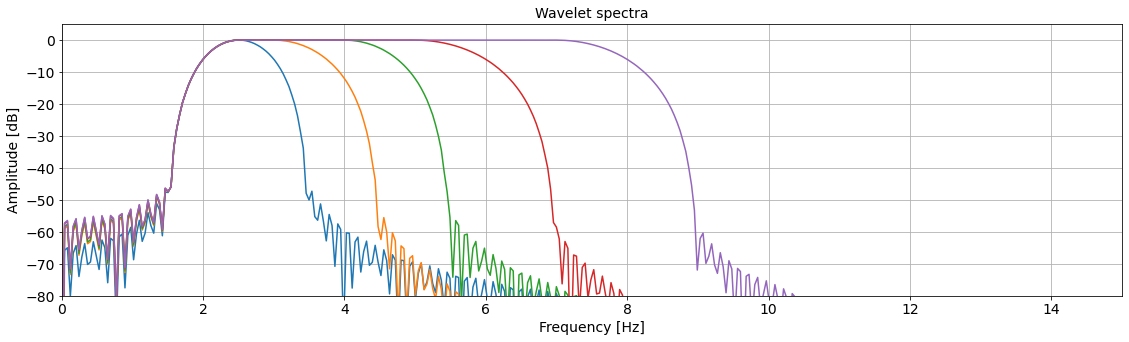

In [15]:
# Read spectra
spectra = genericIO.defaultIO.getVector("wav/BP_Salt_temp_spec.H")
spectra_Nd = spectra.getNdArray()
spectraHyper = spectra.getHyper()

# Read dimensions
freq_axis = spectraHyper.getAxis(1)
nf = freq_axis.n
of = freq_axis.o
df = freq_axis.d

# Display wavelets in time
fig, ax = plt.subplots(figsize=(19,5))
freq_range = np.linspace(of, of+(nf-1)*df, nf)
plt.plot(freq_range, spectra_Nd.T)
plt.title('Wavelet spectra'), plt.xlabel("Frequency [Hz]"), plt.ylabel("Amplitude [dB]")
ax.autoscale(enable=True, axis='x', tight=True)
plt.ylim([-80, 5])
plt.xlim([0, 15])
plt.grid()
plt.show()


## Generate data
In this notebook, we generate noise-free acoustic isotropic constant-density pressure data 

In [20]:
%%bash

# 2-3 Hz 
${ACO_GPU_PACK}/bin/nonlinearPythonFloatMain.py par=par/BP_Salt-fwi-2-9.p vel=vel/BP_Salt-trueVel.pad.H model=wav/BP_Salt-fwi-wav-2-3.H data=dat/BP_Salt-fwi-dat-2-3.H info=0 nGpu=4 &&\

# 2-4 Hz 
${ACO_GPU_PACK}/bin/nonlinearPythonFloatMain.py par=par/BP_Salt-fwi-2-9.p vel=vel/BP_Salt-trueVel.pad.H model=wav/BP_Salt-fwi-wav-2-4.H data=dat/BP_Salt-fwi-dat-2-4.H info=0 nGpu=4 &&\

# 2-5 Hz 
${ACO_GPU_PACK}/bin/nonlinearPythonFloatMain.py par=par/BP_Salt-fwi-2-9.p vel=vel/BP_Salt-trueVel.pad.H model=wav/BP_Salt-fwi-wav-2-5.H data=dat/BP_Salt-fwi-dat-2-5.H info=0 nGpu=4 &&\

# 2-7 Hz 
${ACO_GPU_PACK}/bin/nonlinearPythonFloatMain.py par=par/BP_Salt-fwi-2-9.p vel=vel/BP_Salt-trueVel.pad.H model=wav/BP_Salt-fwi-wav-2-7.H data=dat/BP_Salt-fwi-dat-2-7.H info=0 nGpu=4 &&\

# 2-9 Hz 
${ACO_GPU_PACK}/bin/nonlinearPythonFloatMain.py par=par/BP_Salt-fwi-2-9.p vel=vel/BP_Salt-trueVel.pad.H model=wav/BP_Salt-fwi-wav-2-9.H data=dat/BP_Salt-fwi-dat-2-9.H info=0 nGpu=4


-------------------------------------------------------------------
------------------ Running Python nonlinear forward ---------------
-------------------- Single precision Python code -----------------
-------------------------------------------------------------------

-------------------------------------------------------------------
--------------------------- All done ------------------------------
-------------------------------------------------------------------

-------------------------------------------------------------------
------------------ Running Python nonlinear forward ---------------
-------------------- Single precision Python code -----------------
-------------------------------------------------------------------

-------------------------------------------------------------------
--------------------------- All done ------------------------------
-------------------------------------------------------------------

--------------------------------------------

/opt/conda/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile
/opt/conda/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile
/opt/conda/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile
/opt/conda/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile
/opt/conda/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will b

## Read and display data

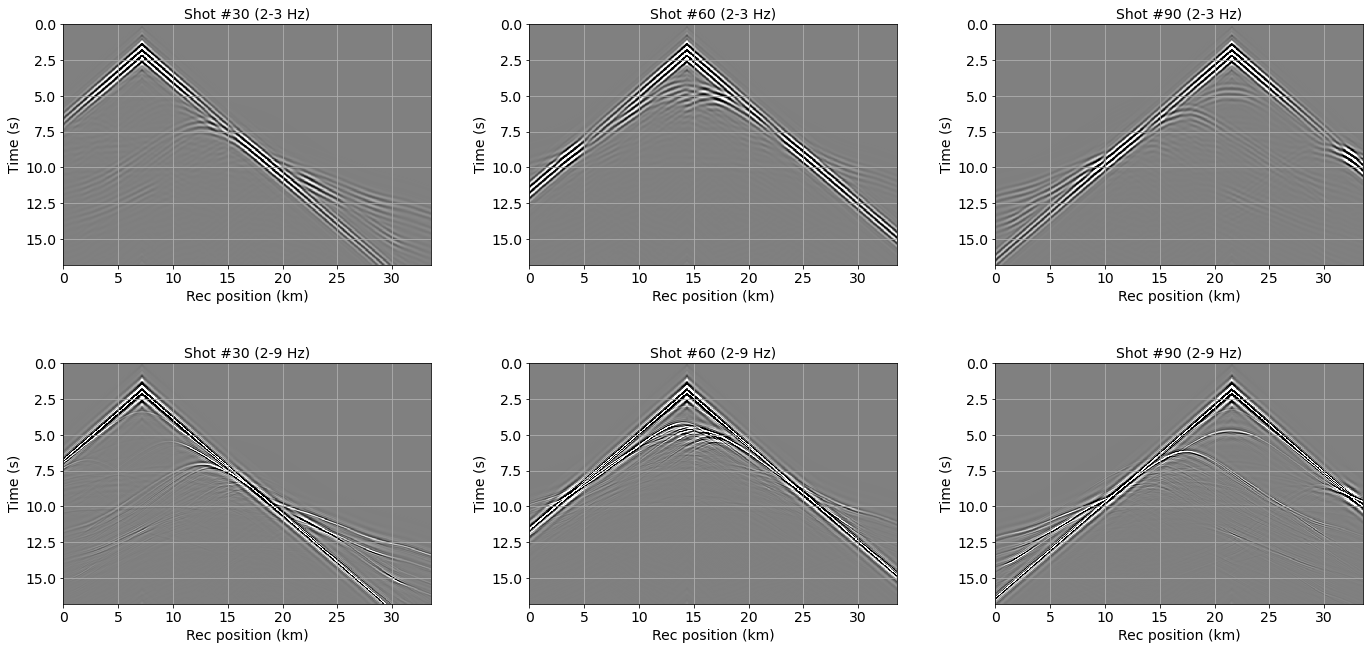

In [25]:
# Read data
data_2_3 = genericIO.defaultIO.getVector("./dat/BP_Salt-fwi-dat-2-3.H")
data_2_4 = genericIO.defaultIO.getVector("./dat/BP_Salt-fwi-dat-2-4.H")
data_2_5 = genericIO.defaultIO.getVector("./dat/BP_Salt-fwi-dat-2-5.H")
data_2_7 = genericIO.defaultIO.getVector("./dat/BP_Salt-fwi-dat-2-7.H")
data_2_9 = genericIO.defaultIO.getVector("./dat/BP_Salt-fwi-dat-2-9.H")

# Display data
data_2_3_nd = data_2_3.getNdArray()
data_2_4_nd = data_2_4.getNdArray()
data_2_5_nd = data_2_5.getNdArray()
data_2_7_nd = data_2_7.getNdArray()
data_2_9_nd = data_2_9.getNdArray()

# Clipping
pclip=98
clip = np.percentile(np.abs(data_2_9_nd), pclip)

# Dimensions
o_rec = data_2_9.getHyper().getAxis(2).o
d_rec = data_2_9.getHyper().getAxis(2).d
n_rec = data_2_9.getHyper().getAxis(2).n
rec_range = np.linspace(o_rec, o_rec+(n_rec-1)*d_rec, n_rec)

# Display shot gathers
fig, axs = plt.subplots(2, 3, figsize=(20, 10))

# First frequency band: 4-6 Hz
shot1 = 30
axs[0,0].pcolormesh(rec_range, time_range, data_2_3_nd[shot1].T,vmin=-clip,vmax=clip)
axs[0,0].invert_yaxis()
axs[0,0].grid()
axs[0,0].set_ylabel('Time (s)')
axs[0,0].set_xlabel('Rec position (km)')
axs[0,0].set_title('Shot #' + str(shot1) + " (2-3 Hz)")

shot2 = 60
axs[0,1].pcolormesh(rec_range, time_range, data_2_3_nd[shot2].T,vmin=-clip,vmax=clip)
axs[0,1].invert_yaxis()
axs[0,1].grid()
axs[0,1].set_ylabel('Time (s)')
axs[0,1].set_xlabel('Rec position (km)')
axs[0,1].set_title('Shot #' + str(shot2) + " (2-3 Hz)")

shot3 = 90
axs[0,2].pcolormesh(rec_range, time_range, data_2_3_nd[shot3].T,vmin=-clip,vmax=clip)
axs[0,2].invert_yaxis()
axs[0,2].grid()
axs[0,2].set_ylabel('Time (s)')
axs[0,2].set_xlabel('Rec position (km)')
axs[0,2].set_title('Shot #' + str(shot3) + " (2-3 Hz)")

# Last frequency band: 4-13 Hz
axs[1,0].pcolormesh(rec_range, time_range, data_2_9_nd[shot1].T,vmin=-clip,vmax=clip)
axs[1,0].invert_yaxis()
axs[1,0].grid()
axs[1,0].set_ylabel('Time (s)')
axs[1,0].set_xlabel('Rec position (km)')
axs[1,0].set_title('Shot #' + str(shot1) + " (2-9 Hz)")

axs[1,1].pcolormesh(rec_range, time_range, data_2_9_nd[shot2].T,vmin=-clip,vmax=clip)
axs[1,1].invert_yaxis()
axs[1,1].grid()
axs[1,1].set_ylabel('Time (s)')
axs[1,1].set_xlabel('Rec position (km)')
axs[1,1].set_title('Shot #' + str(shot2) + " (2-9 Hz)")

axs[1,2].pcolormesh(rec_range, time_range, data_2_9_nd[shot3].T,vmin=-clip,vmax=clip)
axs[1,2].invert_yaxis()
axs[1,2].grid()
axs[1,2].set_ylabel('Time (s)')
axs[1,2].set_xlabel('Rec position (km)')
axs[1,2].set_title('Shot #' + str(shot3) + " (2-9 Hz)")

plt.tight_layout(pad=3.0)
plt.show()

## Conventional data-space multi-scale FWI
* We apply conventional data-space multi-scale FWI using 5 frequency bands: 2-3 Hz, 2-4 Hz, 2-5 Hz, 2-7 Hz, and 2-9 Hz
* We show that FWI converges to an unsatisfactory solution

In [18]:
%%bash

${ACO_GPU_PACK}/bin/fwiMain.py par=par/BP_Salt-fwi-2-9.p sources=wav/BP_Salt-fwi-wav-2-3.H vel=vel/BP_Salt-initVel1.pad.H data=dat/BP_Salt-fwi-dat-2-3.H nIter=500 folder=BP_Salt-fwi-2-3Hz minBound=1.3 maxBound=5.3 nGpu=4 solver=lbfgs &&\
${ACO_GPU_PACK}/bin/fwiMain.py par=par/BP_Salt-fwi-2-9.p sources=wav/BP_Salt-fwi-wav-2-4.H vel=BP_Salt-fwi-2-3Hz/BP_Salt-fwi-2-3Hz_inv_mod.H data=dat/BP_Salt-fwi-dat-2-4.H nIter=500 folder=BP_Salt-fwi-2-4Hz minBound=1.3 maxBound=5.3 nGpu=4 solver=lbfgs &&\
${ACO_GPU_PACK}/bin/fwiMain.py par=par/BP_Salt-fwi-2-9.p sources=wav/BP_Salt-fwi-wav-2-5.H vel=BP_Salt-fwi-2-4Hz/BP_Salt-fwi-2-4Hz_inv_mod.H data=dat/BP_Salt-fwi-dat-2-5.H nIter=500 folder=BP_Salt-fwi-2-5Hz minBound=1.3 maxBound=5.3 nGpu=4 solver=lbfgs &&\
${ACO_GPU_PACK}/bin/fwiMain.py par=par/BP_Salt-fwi-2-9.p sources=wav/BP_Salt-fwi-wav-2-7.H vel=BP_Salt-fwi-2-5Hz/BP_Salt-fwi-2-5Hz_inv_mod.H data=dat/BP_Salt-fwi-dat-2-7.H nIter=500 folder=BP_Salt-fwi-2-7Hz minBound=1.3 maxBound=5.3 nGpu=4 solver=lbfgs &&\
${ACO_GPU_PACK}/bin/fwiMain.py par=par/BP_Salt-fwi-2-9.p sources=wav/BP_Salt-fwi-wav-2-9.H vel=BP_Salt-fwi-2-7Hz/BP_Salt-fwi-2-7Hz_inv_mod.H data=dat/BP_Salt-fwi-dat-2-9.H nIter=500 folder=BP_Salt-fwi-2-9Hz minBound=1.3 maxBound=5.3 nGpu=4 solver=lbfgs

-------------------------------------------------------------------
------------------------ Conventional FWI -------------------------
-------------------------------------------------------------------

--- Using gradient masking ---
--- User has provided a gradient mask file ---
##########################################################################################
Broyden-Fletcher-Goldfarb-Shanno (BFGS) algorithm 
Restart folder: /net/vision/scr2/gbarnier/restart_2022-05-12T20-17-15.539523/
##########################################################################################

iter = 0, obj = 3.69753e-07, resnorm = 8.60e-04, gradnorm = 1.26e-08, feval = 1, geval = 1
iter = 1, obj = 3.00768e-07, resnorm = 7.76e-04, gradnorm = 1.04e-08, feval = 2, geval = 2
iter = 2, obj = 2.09662e-07, resnorm = 6.48e-04, gradnorm = 1.13e-08, feval = 3, geval = 3
iter = 3, obj = 1.86110e-07, resnorm = 6.10e-04, gradnorm = 7.49e-09, feval = 4, geval = 4
Terminate: maximum number of iterations r

/opt/conda/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile
/opt/conda/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile
/opt/conda/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile
/opt/conda/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile
/opt/conda/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will b

## Display FWI results

### Objective functions

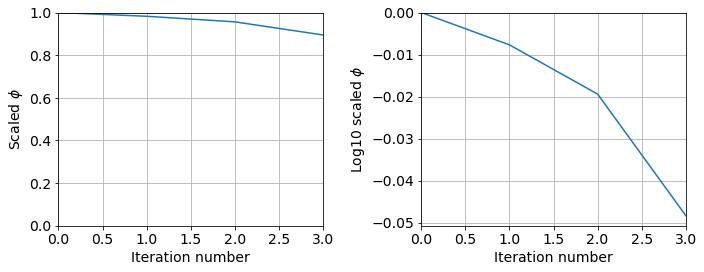

In [20]:
############# Objective functions #############
# Read file 
obj_fwi_2_3 = genericIO.defaultIO.getVector("BP_Salt-fwi-2-3Hz/BP_Salt-fwi-2-3Hz_obj.H")
obj_fwi_2_4 = genericIO.defaultIO.getVector("BP_Salt-fwi-2-4Hz/BP_Salt-fwi-2-4Hz_obj.H")
obj_fwi_2_5 = genericIO.defaultIO.getVector("BP_Salt-fwi-2-5Hz/BP_Salt-fwi-2-5Hz_obj.H")
obj_fwi_2_7 = genericIO.defaultIO.getVector("BP_Salt-fwi-2-7Hz/BP_Salt-fwi-2-7Hz_obj.H")
obj_fwi_2_9 = genericIO.defaultIO.getVector("BP_Salt-fwi-2-9Hz/BP_Salt-fwi-2-9Hz_obj.H")

# Convert to numpy array
obj_fwi_2_3_nd = obj_fwi_2_3.getNdArray()
obj_fwi_2_4_nd = obj_fwi_2_4.getNdArray()
obj_fwi_2_5_nd = obj_fwi_2_5.getNdArray()
obj_fwi_2_7_nd = obj_fwi_2_7.getNdArray()
obj_fwi_2_9_nd = obj_fwi_2_9.getNdArray()

# Plot 
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(obj_fwi_2_3_nd/obj_fwi_2_3_nd[0])
plt.xlabel("Iteration number",fontsize=14)
plt.ylabel("Scaled $\phi$",fontsize=14)
ax = plt.gca() 
plt.ylim([0,1])
plt.grid()
ax.autoscale(enable=True, axis='x', tight=True)
plt.subplot(122)
plt.plot(np.log10(obj_fwi_2_3_nd/obj_fwi_2_3_nd[0]))
plt.xlabel("Iteration number",fontsize=14)
plt.ylabel("Log10 scaled $\phi$",fontsize=14)
ax = plt.gca() 
plt.ylim([None,0])
plt.grid()
ax.autoscale(enable=True, axis='x', tight=True)
plt.tight_layout()



### FWI inverted models for each frequency band

In [21]:
%%bash

# Remove padding from inverted models
Window3d n1=215 f1=55 n2=840 f2=55 < BP_Salt-fwi-2-3Hz/BP_Salt-fwi-2-3Hz_inv_mod.H > BP_Salt_inv_mod_2_3.H &&\
Window3d n1=215 f1=55 n2=840 f2=55 < BP_Salt-fwi-2-4Hz/BP_Salt-fwi-2-4Hz_inv_mod.H > BP_Salt_inv_mod_2_4.H &&\
Window3d n1=215 f1=55 n2=840 f2=55 < BP_Salt-fwi-2-5Hz/BP_Salt-fwi-2-5Hz_inv_mod.H > BP_Salt_inv_mod_2_5.H &&\
Window3d n1=215 f1=55 n2=840 f2=55 < BP_Salt-fwi-2-7Hz/BP_Salt-fwi-2-7Hz_inv_mod.H > BP_Salt_inv_mod_2_7.H &&\
Window3d n1=215 f1=55 n2=840 f2=55 < BP_Salt-fwi-2-9Hz/BP_Salt-fwi-2-9Hz_inv_mod.H > BP_Salt_inv_mod_2_9.H 


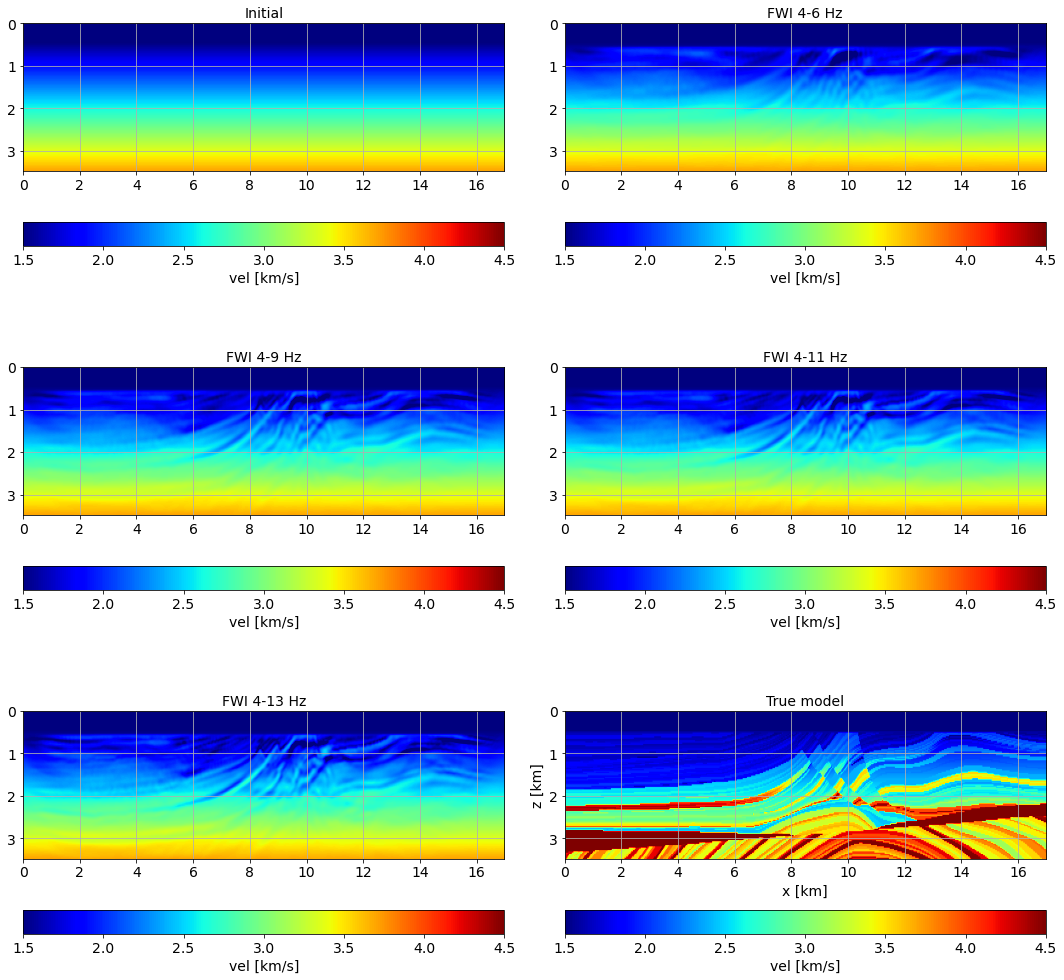

In [32]:
# Read inverted models
model_2_3 = genericIO.defaultIO.getVector("BP_Salt_inv_mod_2_3.H")
model_2_4 = genericIO.defaultIO.getVector("BP_Salt_inv_mod_2_4.H")
model_2_5 = genericIO.defaultIO.getVector("BP_Salt_inv_mod_2_5.H")
model_2_7 = genericIO.defaultIO.getVector("BP_Salt_inv_mod_2_7.H")
model_2_9 = genericIO.defaultIO.getVector("BP_Salt_inv_mod_2_9.H")

# Convert to numpy arrays
model_2_3_nd = model_2_3.getNdArray()
model_2_4_nd = model_2_4.getNdArray()
model_2_5_nd = model_2_5.getNdArray()
model_2_7_nd = model_2_7.getNdArray()
model_2_9_nd = model_2_9.getNdArray()

fig, axs = plt.subplots(3, 2, figsize=(15, 15))

# Plot Initial velocity model
img0_0 = axs[0,0].imshow(vel_init_nd.T,cmap='jet', vmin=vel_true_nd.min(), vmax=vel_true_nd.max(), extent=(ox, (ox+(nx-1)*dx), (oz+(nz-1)*dz), oz), aspect=1.5)
axs[0,0].set_title("Initial"), plt.xlabel("x [km]"), plt.ylabel("z [km]")
fig.colorbar(img0_0, ax=axs[0,0], orientation="horizontal", label="vel [km/s]")
axs[0,0].grid()

# Plot 2-4 Hz velocity model
img0_1 = axs[0,1].imshow(model_2_4.T,cmap='jet', vmin=vel_true_nd.min(), vmax=vel_true_nd.max(), extent=(ox, (ox+(nx-1)*dx), (oz+(nz-1)*dz), oz), aspect=1.5)
axs[0,1].set_title("FWI 4-6 Hz"), plt.xlabel("x [km]"), plt.ylabel("z [km]")
fig.colorbar(img0_1, ax=axs[0,1], orientation="horizontal", label="vel [km/s]")
axs[0,1].grid()

# Plot 2-5 Hz velocity model
img1_0 = axs[1,0].imshow(model_2_5_nd.T,cmap='jet', vmin=vel_true_nd.min(), vmax=vel_true_nd.max(), extent=(ox, (ox+(nx-1)*dx), (oz+(nz-1)*dz), oz), aspect=1.5)
axs[1,0].set_title("FWI 4-9 Hz"), plt.xlabel("x [km]"), plt.ylabel("z [km]")
fig.colorbar(img1_0, ax=axs[1,0], orientation="horizontal", label="vel [km/s]")
axs[1,0].grid()

# Plot 2-7 Hz velocity model
img1_1 = axs[1,1].imshow(model_2_7_nd.T,cmap='jet', vmin=vel_true_nd.min(), vmax=vel_true_nd.max(), extent=(ox, (ox+(nx-1)*dx), (oz+(nz-1)*dz), oz), aspect=1.5)
axs[1,1].set_title("FWI 4-11 Hz"), plt.xlabel("x [km]"), plt.ylabel("z [km]")
fig.colorbar(img1_1, ax=axs[1,1], orientation="horizontal", label="vel [km/s]")
axs[1,1].grid()

# Plot 2-9 Hz velocity model
img2_0 = axs[2,0].imshow(model_2_9_nd.T,cmap='jet', vmin=vel_true_nd.min(), vmax=vel_true_nd.max(), extent=(ox, (ox+(nx-1)*dx), (oz+(nz-1)*dz), oz), aspect=1.5)
axs[2,0].set_title("FWI 4-13 Hz"), plt.xlabel("x [km]"), plt.ylabel("z [km]")
fig.colorbar(img2_0, ax=axs[2,0], orientation="horizontal", label="vel [km/s]")
axs[2,0].grid()

# Plot true velocity model
img2_1 = axs[2,1].imshow(vel_true_nd.T,cmap='jet', vmin=vel_true_nd.min(), vmax=vel_true_nd.max(), extent=(ox, (ox+(nx-1)*dx), (oz+(nz-1)*dz), oz), aspect=1.5)
axs[2,1].set_title("True model"), plt.xlabel("x [km]"), plt.ylabel("z [km]")
fig.colorbar(img2_1, ax=axs[2,1], orientation="horizontal", label="vel [km/s]")
axs[2,1].grid()


plt.tight_layout()
    
  
    


# IV. FWIME

## Wavelet 
* The FWIME wavelet contains less low-frequency energy than for FWI to make the exercise even more difficult

In [39]:
%%bash

############ Wavelet for FWIME ############
# 4-13 Hz
${ACO_GPU_PACK}/bin/waveletFloatMain.py par=par/BP_Salt-fwime-3-9.p timeDelay=1.5 f1=3 f2=4 f3=7 f4=9 type=ali wavelet=wav/BP_Salt-fwime-wav-3-9.H

## Data 
* The FWIME data contain less low-frequency energy than for FWI to make the exercise even more difficult

In [41]:
%%bash

############ Data ############
${ACO_GPU_PACK}/bin/nonlinearPythonFloatMain.py par=par/BP_Salt-fwime-3-9.p vel=vel/BP_Salt-trueVel.pad.H model=wav/BP_Salt-fwime-wav-3-9.H data=dat/BP_Salt-fwime-data-3-9.H info=0 nGpu=4

-------------------------------------------------------------------
------------------ Running Python nonlinear forward ---------------
-------------------- Single precision Python code -----------------
-------------------------------------------------------------------

-------------------------------------------------------------------
--------------------------- All done ------------------------------
-------------------------------------------------------------------



/opt/conda/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


## Upper and lower velocity bounds computation
* We choose lower/upper velocity values $v_{min}$ and $v_{max}$ to prevent the velocity model from taking values that would create FD instability or dispersion
* However, the step length calculation and the model updates are conducted on the spline grid (see Barnier et. al, 2022), so we need to express these bounds on the spline grid
* For each spline grid, we create two constant velocity models on the FD grid whose values are set to $v_{min}$ and $v_{max}$, respectively
* We map these constant velocity models onto the spline grid by applying the adjoint of the spline mapping operator
* We use the output of this adjoint mapping as lower/upper bounds on the spline grid (which is where our unknown model is parametrized)

In [2]:
%%bash

################### Bounds for spline grid 1 ###################
# Max bound
Vel n1=215 n2=840 n3=1 d1=0.04 d2=0.04 d3=0.04 vc=5.0 > junkMax.H &&\
${ACO_GPU_PACK}/bin/padFileGpuMain zPad=50 xPad=50 model=junkMax.H data=junkMax.pad.H &&\
${ACO_GPU_PACK}/bin/interpBSplineMain.py nDim=2 data=junkMax.pad.H model=vel/BP_Salt-fwime-3-9-spline1-maxBound.H adj=1 par=par/BP_Salt-fwime-3-9-spline1.p vel=vel/BP_Salt_velDummy.pad.H &&\

# Min bound
Vel n1=215 n2=840 n3=1 d1=0.04 d2=0.04 d3=0.04 vc=1.3 > junkMin.H &&\
${ACO_GPU_PACK}/bin/padFileGpuMain zPad=50 xPad=50 model=junkMin.H data=junkMin.pad.H &&\
${ACO_GPU_PACK}/bin/interpBSplineMain.py nDim=2 data=junkMin.pad.H model=vel/BP_Salt-fwime-3-9-spline1-minBound.H adj=1 par=par/BP_Salt-fwime-3-9-spline1.p vel=vel/BP_Salt_velDummy.pad.H &&\

################### Bounds for spline grid 2 ###################
# Max bound
Vel n1=215 n2=840 n3=1 d1=0.04 d2=0.04 d3=0.04 vc=5.0 > junkMax.H &&\
${ACO_GPU_PACK}/bin/padFileGpuMain zPad=50 xPad=50 model=junkMax.H data=junkMax.pad.H &&\
${ACO_GPU_PACK}/bin/interpBSplineMain.py nDim=2 data=junkMax.pad.H model=vel/BP_Salt-fwime-3-9-spline2b-maxBound.H adj=1 par=par/BP_Salt-fwime-3-9-spline2b.p vel=vel/BP_Salt_velDummy.pad.H &&\

# Min bound
Vel n1=215 n2=840 n3=1 d1=0.04 d2=0.04 d3=0.04 vc=1.3 > junkMin.H &&\
${ACO_GPU_PACK}/bin/padFileGpuMain zPad=50 xPad=50 model=junkMin.H data=junkMin.pad.H &&\
${ACO_GPU_PACK}/bin/interpBSplineMain.py nDim=2 data=junkMin.pad.H model=vel/BP_Salt-fwime-3-9-spline2b-minBound.H adj=1 par=par/BP_Salt-fwime-3-9-spline2b.p vel=vel/BP_Salt_velDummy.pad.H &&\

################### Bounds for spline grid 3 ###################
# Max bound
Vel n1=215 n2=840 n3=1 d1=0.04 d2=0.04 d3=0.04 vc=5.0 > junkMax.H &&\
${ACO_GPU_PACK}/bin/padFileGpuMain zPad=50 xPad=50 model=junkMax.H data=junkMax.pad.H &&\
${ACO_GPU_PACK}/bin/interpBSplineMain.py nDim=2 data=junkMax.pad.H model=vel/BP_Salt-fwime-3-9-spline2-maxBound.H adj=1 par=par/BP_Salt-fwime-3-9-spline2.p vel=vel/BP_Salt_velDummy.pad.H &&\

# Min bound
Vel n1=215 n2=840 n3=1 d1=0.04 d2=0.04 d3=0.04 vc=1.3 > junkMin.H &&\
${ACO_GPU_PACK}/bin/padFileGpuMain zPad=50 xPad=50 model=junkMin.H data=junkMin.pad.H &&\
${ACO_GPU_PACK}/bin/interpBSplineMain.py nDim=2 data=junkMin.pad.H model=vel/BP_Salt-fwime-3-9-spline2-minBound.H adj=1 par=par/BP_Salt-fwime-3-9-spline2.p vel=vel/BP_Salt_velDummy.pad.H &&\

################### Bounds for spline grid 4 ###################
# Max bound
Vel n1=215 n2=840 n3=1 d1=0.04 d2=0.04 d3=0.04 vc=5.0 > junkMax.H &&\
${ACO_GPU_PACK}/bin/padFileGpuMain zPad=50 xPad=50 model=junkMax.H data=junkMax.pad.H &&\
${ACO_GPU_PACK}/bin/interpBSplineMain.py nDim=2 data=junkMax.pad.H model=vel/BP_Salt-fwime-3-9-spline3-maxBound.H adj=1 par=par/BP_Salt-fwime-3-9-spline3.p vel=vel/BP_Salt_velDummy.pad.H &&\

# Min bound
Vel n1=215 n2=840 n3=1 d1=0.04 d2=0.04 d3=0.04 vc=1.3 > junkMin.H &&\
${ACO_GPU_PACK}/bin/padFileGpuMain zPad=50 xPad=50 model=junkMin.H data=junkMin.pad.H &&\
${ACO_GPU_PACK}/bin/interpBSplineMain.py nDim=2 data=junkMin.pad.H model=vel/BP_Salt-fwime-3-9-spline3-minBound.H adj=1 par=par/BP_Salt-fwime-3-9-spline3.p vel=vel/BP_Salt_velDummy.pad.H &&\

################### Bounds for spline grid 5 ###################
# Max bound
Vel n1=215 n2=840 n3=1 d1=0.04 d2=0.04 d3=0.04 vc=5.0 > junkMax.H &&\
${ACO_GPU_PACK}/bin/padFileGpuMain zPad=50 xPad=50 model=junkMax.H data=junkMax.pad.H &&\
${ACO_GPU_PACK}/bin/interpBSplineMain.py nDim=2 data=junkMax.pad.H model=vel/BP_Salt-fwime-3-9-spline4-maxBound.H adj=1 par=par/BP_Salt-fwime-3-9-spline4.p vel=vel/BP_Salt_velDummy.pad.H &&\

# Min bound
Vel n1=215 n2=840 n3=1 d1=0.04 d2=0.04 d3=0.04 vc=1.3 > junkMin.H &&\
${ACO_GPU_PACK}/bin/padFileGpuMain zPad=50 xPad=50 model=junkMin.H data=junkMin.pad.H &&\
${ACO_GPU_PACK}/bin/interpBSplineMain.py nDim=2 data=junkMin.pad.H model=vel/BP_Salt-fwime-3-9-spline4-minBound.H adj=1 par=par/BP_Salt-fwime-3-9-spline4.p vel=vel/BP_Salt_velDummy.pad.H


 
------------------------ Model padding program --------------------
Original nz = 215 [samples]
Original nx = 840 [samples]
 
zPadMinus = 50 [samples]
zPadPlus = 55 [samples]
xPadMinus = 50 [samples]
xPadPlus = 54 [samples]
 
blockSize = 16 [samples]
FAT = 5 [samples]
 
New nz = 330 [samples including padding and FAT]
New nx = 954 [samples including padding and FAT]
-------------------------------------------------------------------
 
-------------------------------------------------------------------
-------------- Running Spline interpolation adjoint ---------------
-------------------- 2 D B-Splines functions -----------------------
-------------------------------------------------------------------

Time for adjoint =  0.05134296417236328
 
------------------------ Model padding program --------------------
Original nz = 215 [samples]
Original nx = 840 [samples]
 
zPadMinus = 50 [samples]
zPadPlus = 55 [samples]
xPadMinus = 50 [samples]
xPadPlus = 54 [samples]
 
blockSize = 16 [s

## FWIME on spline grid 1

### Generate initial model onto first spline grid
* In step II of this notebook, we created/read the initial velocity model $\mathbf{m}^f_{init}$ defined on the (fine) FD grid 
* We now need to convert it (or map it) onto the first coarse spline grid $c_1$ in order to obtain the initial model for the FWIME inversion, $\mathbf{m}^{c_1}_{init}$
* The mapping is done by finding the unique minimizer of the following loss function:

$\mathbf{m}^{c_1}_{init} = \underset{\mathbf{m}^{c_1}}{\mathrm{argmin}} \; \dfrac{1}{2} \left \| \mathbf{S}_1 \mathbf{m}^{c_1} - \mathbf{m}^f_{init} \right \|_2^2$
* $\mathbf{S}_1$ is the spline mapping operator (from the first coarse spline grid -> fine grid)
* $\mathbf{m}^{c_1}$ corresponds to any model defined on the first spline grid



In [43]:
%%bash

# Create directory spline2dJunk (you might have to create it manually by typing "mkdir spline2dJunk")
# Map initial model onto the first spline grid
${ACO_GPU_PACK}/bin/interpBSplineInvMain.py nDim=2 nIter=50 folder=spline2dJunk vel=vel/BP_Salt_velDummy.pad.H data=vel/BP_Salt-initVel1.pad.H par=par/BP_Salt-fwime-3-9-spline1.p &&\
Cp spline2dJunk/spline2dJunk_inv_mod.H vel/BP_Salt-fwime-3-9-coarseInitMod-spline1.H

##########################################################################################
				LINEAR CONJUGATE GRADIENT  SOLVER
	Restart folder: /net/vision/scr2/gbarnier/restart_2022-05-12T20-56-32.223178/
	Modeling Operator:		Operator
##########################################################################################

iter = 00, obj = 6.06367e+05, resnorm = 1.10e+03, gradnorm = 1.10e+03, feval = 2
iter = 01, obj = 4.35356e+00, resnorm = 2.95e+00, gradnorm = 2.41e+00, feval = 4
iter = 02, obj = 7.97024e-01, resnorm = 1.26e+00, gradnorm = 6.06e-01, feval = 6
iter = 03, obj = 4.14188e-01, resnorm = 9.10e-01, gradnorm = 3.30e-01, feval = 8
iter = 04, obj = 2.61415e-01, resnorm = 7.23e-01, gradnorm = 2.08e-01, feval = 10
iter = 05, obj = 2.07482e-01, resnorm = 6.44e-01, gradnorm = 1.31e-01, feval = 12
iter = 06, obj = 1.80901e-01, resnorm = 6.01e-01, gradnorm = 9.11e-02, feval = 14
iter = 07, obj = 1.69080e-01, resnorm = 5.82e-01, gradnorm = 5.70e-02, feval = 16
iter = 08, obj = 1

### Launch inversion

In [44]:
%%bash

# Launch inversion
${ACO_GPU_PACK}/bin/fwimeMain.py par=par/BP_Salt-fwime-3-9-spline1.p vel=vel/BP_Salt_velDummy.pad.H sources=wav/BP_Salt-fwime-wav-3-9.H data=dat/BP_Salt-fwime-data-3-9.H nGpu=4 folderNl=BP_Salt-fwime-3-9-spline1 modelCoarseInit=vel/BP_Salt-fwime-3-9-coarseInitMod-spline1.H minBoundVector=vel/BP_Salt-fwime-3-9-spline1-minBound.H maxBoundVector=vel/BP_Salt-fwime-3-9-spline1-maxBound.H epsilon=2.5e-4 sloth=1

Process is terminated.


## FWIME on spline grid 2

### Map inverted model: spline 1 -> spline 2
* The output of FWIME on the first spline grid $\mathbf{m}^{c_1}_{final}$ is mapped onto the FD grid:

$\mathbf{m}^f_{1} = \mathbf{S}_1 \mathbf{m}^{c_1}_{final}$

* Then, the analogous inversion procedure as the one done in the previous step is employed to map this model on the second spline grid:

$\mathbf{m}^{c_2}_{init} = \underset{\mathbf{m}^{c_2}}{\mathrm{argmin}} \; \dfrac{1}{2} \left \| \mathbf{S}_2 \mathbf{m}^{c_2} - \mathbf{m}^f_{1} \right \|_2^2$






In [ ]:
%%bash

Window3d n3=1 f3=0 < BP_Salt-fwime-3-9-spline1/BP_Salt-fwime-3-9-spline1_inv_mod.H > junk1.H &&\
# Map inverted model from spline 2b -> FD grid
${ACO_GPU_PACK}/bin/interpBSplineMain.py nDim=2 vel=vel/BP_Salt_velDummy.pad.H model=junk1.H data=vel/BP_Salt-fwime-inv-mod-spline1.pad.H adj=0 par=par/BP_Salt-fwime-3-9-spline1.p &&\
# Map inverted model from FD grid -> spline 2b
${ACO_GPU_PACK}/bin/interpBSplineInvMain.py nDim=2 nIter=50 folder=spline2dJunk vel=vel/BP_Salt_velDummy.pad.H data=vel/BP_Salt-fwime-inv-mod-spline1.pad.H par=par/BP_Salt-fwime-3-9-spline2b.p &&\
Cp spline2dJunk/spline2dJunk_inv_mod.H vel/BP_Salt-fwime-3-9-coarseInitMod-spline2b.H


bash: line 3: reproMarmousi-fwime-4-13-spline1/reproMarmousi-fwime-4-13-spline1_inv_mod.H: No such file or directory
bash: line 5: /bin/interpBSplineMain.py: No such file or directory


CalledProcessError: Command 'b'\n# Extract inverted model\nWindow3d n3=1 f3=0 < reproMarmousi-fwime-4-13-spline1/reproMarmousi-fwime-4-13-spline1_inv_mod.H > junk0.H\n# Map inverted model from spline 1 -> FD grid\n${ACO_GPU_PACK}/bin/interpBSplineMain.py nDim=2 vel=vel/reproMarmousi_velDummy.pad.H model=junk0.H data=vel/Marmousi-fwime-inv-mod-spline1.H adj=0 par=par/reproMarmousi-fwime-4-13-spline1.p\n# Crop model to get rid of absorbing boundaries\n\n'' returned non-zero exit status 127.

### Launch inversion on spline grid 2

In [ ]:
%%bash

# Launch inversion
${ACO_GPU_PACK}/bin/fwimeMain.py par=par/BP_Salt-fwime-3-9-spline2b.p vel=vel/BP_Salt_velDummy.pad.H sources=wav/BP_Salt-fwime-wav-3-9.H data=dat/BP_Salt-fwime-data-3-9.H nGpu=4 folderNl=BP_Salt-fwime-3-9-spline2b modelCoarseInit=vel/BP_Salt-fwime-3-9-coarseInitMod-spline2b.H minBoundVector=vel/BP_Salt-fwime-3-9-spline2b-minBound.H maxBoundVector=vel/BP_Salt-fwime-3-9-spline2b-maxBound.H epsilon=2.5e-4 sloth=1


## FWIME on spline grid 3

### Map inverted model on spline 2 into spline 3

In [ ]:
%%bash

# Extract inverted model from spline 2b inversion
Window3d n3=1 f3=0 < BP_Salt-fwime-3-9-spline2b/BP_Salt-fwime-3-9-spline2b_inv_mod.H > junk1.H &&\
# Map inverted model from spline 2b -> FD grid
${ACO_GPU_PACK}/bin/interpBSplineMain.py nDim=2 vel=vel/BP_Salt_velDummy.pad.H model=junk1.H data=vel/BP_Salt-fwime-inv-mod-spline2b.pad.H adj=0 par=par/BP_Salt-fwime-3-9-spline2b.p &&\
# Map inverted model from FD grid -> spline 2
${ACO_GPU_PACK}/bin/interpBSplineInvMain.py nDim=2 nIter=50 folder=spline2dJunk vel=vel/BP_Salt_velDummy.pad.H data=vel/BP_Salt-fwime-inv-mod-spline2b.pad.H par=par/BP_Salt-fwime-3-9-spline2.p &&\
Cp spline2dJunk/spline2dJunk_inv_mod.H vel/BP_Salt-fwime-3-9-coarseInitMod-spline2.H

### Launch inversion on spline grid 3
* The analogous procedure is employed to map the inverted model on spline 2 -> spline 3

In [4]:
%%bash

${ACO_GPU_PACK}/bin/fwimeMain.py par=par/BP_Salt-fwime-3-9-spline2.p vel=vel/BP_Salt_velDummy.pad.H sources=wav/BP_Salt-fwime-wav-3-9.H data=dat/BP_Salt-fwime-data-3-9.H nGpu=4 folderNl=BP_Salt-fwime-3-9-spline2 modelCoarseInit=vel/BP_Salt-fwime-3-9-coarseInitMod-spline2.H minBoundVector=vel/BP_Salt-fwime-3-9-spline2-minBound.H maxBoundVector=vel/BP_Salt-fwime-3-9-spline2-maxBound.H epsilon=2.5e-4 sloth=1

bash: line 1: /bin/fwimeMain.py: No such file or directory


CalledProcessError: Command 'b'${ACO_GPU_PACK}/bin/fwimeMain.py par=par/reproMarmousi-fwime-4-13-spline3.p vel=vel/reproMarmousi_velDummy.pad.H sources=wav/reproMarmousi-fwime-wav-4-13.H data=dat/reproMarmousi-fwime-data-4-13.H nGpu=4 folderNl=reproMarmousi-fwime-4-13-spline3 modelCoarseInit=vel/reproMarmousi-fwime-4-13-coarseInitMod-spline3.H minBoundVector=vel/reproMarmousi-fwime-4-13-spline3-minBound.H maxBoundVector=vel/reproMarmousi-fwime-4-13-spline3-maxBound.H epsilon=3.0e-4 sloth=1\n'' returned non-zero exit status 127.

## FWIME on spline grid 4

### Map inverted model on spline 3 into spline 4
* The analogous procdure is employed to map the inverted model on spline 3 -> spline 4

In [ ]:
%%bash

# Extract inverted model
Window3d n3=1 f3=0 < BP_Salt-fwime-3-9-spline2/BP_Salt-fwime-3-9-spline2_inv_mod.H > junk1.H &&\
# Map inverted model -> FD grid
${ACO_GPU_PACK}/${B}/interpBSplineMain.py nDim=2 vel=vel/BP_Salt_velDummy.pad.H model=junk1.H data=vel/BP_Salt-fwime-inv-mod-spline2.pad.H adj=0 par=par/BP_Salt-fwime-3-9-spline2.p &&\
# Map inverted model from FD grid to coarse grid
${ACO_GPU_PACK}/${B}/interpBSplineInvMain.py nDim=2 nIter=50 folder=spline2dJunk vel=vel/BP_Salt_velDummy.pad.H data=vel/BP_Salt-fwime-inv-mod-spline2.pad.H par=par/BP_Salt-fwime-3-9-spline3.p &&\
Cp spline2dJunk/spline2dJunk_inv_mod.H $@

### Launch inversion on fourth spline grid

In [ ]:
%%bash

${ACO_GPU_PACK}/bin/fwimeMain.py par=par/BP_Salt-fwime-3-9-spline3.p vel=vel/BP_Salt_velDummy.pad.H sources=wav/BP_Salt-fwime-wav-3-9.H data=dat/BP_Salt-fwime-data-3-9.H nGpu=4 folderNl=BP_Salt-fwime-3-9-spline3 modelCoarseInit=vel/BP_Salt-fwime-3-9-coarseInitMod-spline3.H minBoundVector=vel/BP_Salt-fwime-3-9-spline3-minBound.H maxBoundVector=vel/BP_Salt-fwime-3-9-spline3-maxBound.H epsilon=2.5e-4 sloth=1

## FWIME on spline grid 5

### Map inverted model on spline 4 into spline 5
* The analogous procdure is employed to map the inverted model on spline 4 -> spline 5

In [3]:
%%bash

Window3d n3=1 f3=0 < BP_Salt-fwime-3-9-spline4/BP_Salt-fwime-3-9-spline4_inv_mod.H > junk1.H &&\
# Map inverted model from spline 3 -> FD grid
${ACO_GPU_PACK}/bin/interpBSplineMain.py nDim=2 vel=vel/BP_Salt_velDummy.pad.H model=junk1.H data=vel/BP_Salt-fwime-inv-mod-spline3.pad.H adj=0 par=par/BP_Salt-fwime-3-9-spline3.p &&\
# Map inverted model from FD grid -> spline 4
${ACO_GPU_PACK}/bin/interpBSplineInvMain.py nDim=2 nIter=50 folder=spline2dJunk vel=vel/BP_Salt_velDummy.pad.H data=vel/BP_Salt-fwime-inv-mod-spline3.pad.H par=par/BP_Salt-fwime-3-9-spline4.p &&\
Cp spline2dJunk/spline2dJunk_inv_mod.H vel/BP_Salt-fwime-3-9-coarseInitMod-spline4.H

UsageError: %%bash is a cell magic, but the cell body is empty.


### Launch inversion on fifth spline grid

In [4]:
%%bash

${ACO_GPU_PACK}/bin/fwimeMain.py par=par/BP_Salt-fwime-3-9-spline4.p vel=vel/BP_Salt_velDummy.pad.H sources=wav/BP_Salt-fwime-wav-3-9.H data=dat/BP_Salt-fwime-data-3-9.H nGpu=4 folderNl=BP_Salt-fwime-3-9-spline4 modelCoarseInit=vel/BP_Salt-fwime-3-9-coarseInitMod-spline4.H minBoundVector=vel/BP_Salt-fwime-3-9-spline4-minBound.H maxBoundVector=vel/BP_Salt-fwime-3-9-spline4-maxBound.H epsilon=2.5e-4 sloth=1

-------------------------------------------------------------------
------------------------------ FWIME ------------------------------
-------------------------------------------------------------------

--- Using spline interpolation ---
--- Using gradient masking ---
--- User has provided a gradient mask file ---


why exited 
/opt/conda/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile
Traceback (most recent call last):
  File "/opt/acoustic_2d/local//bin/fwimeMain.py", line 86, in <module>
    _,_,_,_,_,sourcesSignalsVector,_,_=Acoustic_iso_float.BornOpInitFloat(sys.argv,client)
  File "/opt/acoustic_2d/local/lib/python3.7/Acoustic_iso_float.py", line 837, in BornOpInitFloat
    sourcesSignalsFloat=genericIO.defaultIO.getVector(sourcesFile,ndims=2)
  File "/opt/acoustic_2d/local/lib/python3.7/genericIO.py", line 1235, in getVector
    file = self.getRegFile(tag, **kw)
  File "/opt/acoustic_2d/local/lib/python3.7/genericIO.py", line 1177, in getRegFile
    x = regFile(self.cppMode, tag, **kw)
  File "/opt/acoustic_2d/local/lib/python3.7/genericIO.py", line 199, in __init__
    self.usage], ndimMax)
RuntimeError: can not open file wav/rep

CalledProcessError: Command 'b'${ACO_GPU_PACK}/bin/fwimeMain.py par=par/reproBpSalt-fwime-3-9-spline4.p vel=vel/reproBpSalt_velDummy.pad.H sources=wav/reproBpSalt-fwime-wav-3-9.H data=dat/reproBpSalt-fwime-data-3-9.H nGpu=4 folderNl=reproBpSalt-fwime-3-9-spline4 modelCoarseInit=vel/reproBpSalt-fwime-3-9-coarseInitMod-spline4.H minBoundVector=vel/reproBpSalt-fwime-3-9-spline4-minBound.H maxBoundVector=vel/reproBpSalt-fwime-3-9-spline4-maxBound.H epsilon=2.5e-4 sloth=1\n'' returned non-zero exit status 1.

## FWIME on spline grid 6 (FD grid)

### Map inverted model on spline 5 into spline 6
* The analogous procdure is employed to map the inverted model on spline 5 -> spline 6

In [ ]:
%%bash

Window3d n3=1 f3=0 < BP_Salt-fwime-3-9-spline4/BP_Salt-fwime-3-9-spline4_inv_mod.H > junk1.H &&\
# Map inverted model from spline 4 -> FD grid
${ACO_GPU_PACK}/bin/interpBSplineIterMain.py nDim=2 vel=vel/BP_Salt-velDummy.pad.H model=junk1.H data=vel/BP_Salt-fwime-inv-mod-spline4.pad.H adj=0 par=par/BP_Salt-fwime-3-9-spline4.p

### Launch inversion on FD spline grid

In [ ]:
%%bash

${ACO_GPU_PACK}/bin/fwimeMain.py par=par/BP_Salt-fwime-3-9-noSpline.p vel=vel/BP_Salt-fwime-3-9-coarseInitMod-noSpline.H sources=wav/BP_Salt-fwime-wav-3-9.H data=dat/BP_Salt-fwime-data-3-9.H nGpu=4 folderNl=BP_Salt-fwime-3-9-noSpline minBound=1.3 maxBound=5.0 epsilon=2.5e-4 sloth=1

# V. FWIME results analysis

## FWIME objective functions

### Concatenate all components of objective functions

In [ ]:
%%bash

# Concatenate all objective functions components?   
Cat axis=1 BP_Salt-fwime-3-9-spline1/BP_Salt-fwime-3-9-spline1_obj.H BP_Salt-fwime-3-9-spline2b/BP_Salt-fwime-3-9-spline2b_obj.H BP_Salt-fwime-3-9-spline2/BP_Salt-fwime-3-9-spline2_obj.H BP_Salt-fwime-3-9-spline3/BP_Salt-fwime-3-9-spline3_obj.H BP_Salt-fwime-3-9-spline4/BP_Salt-fwime-3-9-spline4_obj.H BP_Salt-fwime-3-9-noSpline/BP_Salt-fwime-3-9-noSpline_obj.H > BP_Salt_fwime_obj_total.H &&\
Cat axis=1 BP_Salt-fwime-3-9-spline1/BP_Salt-fwime-3-9-spline1_obj_comp1.H BP_Salt-fwime-3-9-spline2b/BP_Salt-fwime-3-9-spline2b_obj_comp1.H BP_Salt-fwime-3-9-spline2/BP_Salt-fwime-3-9-spline2_obj_comp1.H BP_Salt-fwime-3-9-spline3/BP_Salt-fwime-3-9-spline3_obj_comp1.H BP_Salt-fwime-3-9-spline4/BP_Salt-fwime-3-9-spline4_obj_comp1.H BP_Salt-fwime-3-9-noSpline/BP_Salt-fwime-3-9-noSpline_obj_comp1.H > BP_Salt_fwime_obj_data.H &&\
Cat axis=1 BP_Salt-fwime-3-9-spline1/BP_Salt-fwime-3-9-spline1_obj_comp2.H BP_Salt-fwime-3-9-spline2b/BP_Salt-fwime-3-9-spline2b_obj_comp2.H BP_Salt-fwime-3-9-spline2/BP_Salt-fwime-3-9-spline2_obj_comp1.H BP_Salt-fwime-3-9-spline3/BP_Salt-fwime-3-9-spline3_obj_comp2.H BP_Salt-fwime-3-9-spline4/BP_Salt-fwime-3-9-spline4_obj_comp2.H BP_Salt-fwime-3-9-noSpline/BP_Salt-fwime-3-9-noSpline_obj_comp2.H > BP_Salt_fwime_obj_annihilator.H 

### Read and display objective function

In [ ]:
# Read FWIME objective functions

# Spline 1
fwime_obj_total = genericIO.defaultIO.getVector("BP_Salt_fwime_obj_total.H")
fwime_obj_data = genericIO.defaultIO.getVector("BP_Salt_fwime_obj_data.H")
fwime_obj_annihilator = genericIO.defaultIO.getVector("BP_Salt_fwime_obj_annihilator.H")

# Convert from SEP arrays to numpy arrays
fwime_obj_total_nd = fwime_obj_total.getNdArray()
fwime_obj_data_nd = fwime_obj_data.getNdArray()
fwime_obj_annihilator_nd = fwime_obj_annihilator.getNdArray()

# Plot normalized objective function
fwime_obj_total_norm = fwime_obj_total_nd/fwime_obj_total_nd[0]
fwime_obj_data_norm = fwime_obj_data_nd/fwime_obj_total_nd[0]
fwime_obj_annihilator_norm = fwime_obj_annihilator_nd/fwime_obj_total_nd[0]
plt.figure(figsize=(10,4))

# Normal scale
# plt.subplot(121)
# plt.plot(fwi_obj_norm)
# plt.xlabel("Iteration number",fontsize=14)
# plt.ylabel("Scaled $\phi$",fontsize=14)
# ax = plt.gca() 
# plt.ylim([0,1])
# plt.grid()
# ax.autoscale(enable=True, axis='x', tight=True)

# # Log scale
# plt.subplot(122)
# plt.plot(np.log10(fwi_obj_norm))
# plt.xlabel("Iteration number",fontsize=14)
# plt.ylabel("Log10 scaled $\phi$",fontsize=14)
# ax = plt.gca() 
# plt.ylim([None,0])
# plt.grid()
# ax.autoscale(enable=True, axis='x', tight=True)
# plt.tight_layout()

# # Get dimensions
# wavelet_hyper = wav_4_6.getHyper()
# time_axis = wavelet_hyper.getAxis(1)
# nt = time_axis.n
# ot = time_axis.o
# dt = time_axis.d

# Display wavelets in time
fig, ax = plt.subplots(figsize=(19,5))
time_range = np.linspace(ot, ot+(nt-1)*dt, nt)
plt.plot(fwime_obj_total_norm)
plt.plot(fwime_obj_data_norm)
plt.plot(fwime_obj_annihilator_norm)
plt.title('FWIME objective function'), plt.xlabel("Iteration #"), plt.ylabel("Normalized objective function value")
ax.autoscale(enable=True, axis='x', tight=True)
plt.ylim([0 1])
plt.xlim([0, 300])
plt.grid()
plt.show()



## FWIME inverted models

In [ ]:
%%bash

# Extract and crop inverted models on each spline grids
Window3d n1=215 f1=55 n2=840 f2=55 < vel/BP_Salt-fwime-inv-mod-spline1.pad.H > vel/BP_Salt-fwime-inv-mod-spline1.H &&\ 
Window3d n1=215 f1=55 n2=840 f2=55 < vel/BP_Salt-fwime-inv-mod-spline2.pad.H > vel/BP_Salt-fwime-inv-mod-spline2.H &&\
Window3d n1=215 f1=55 n2=840 f2=55 < vel/BP_Salt-fwime-inv-mod-spline3.pad.H > vel/BP_Salt-fwime-inv-mod-spline3.H &&\
Window3d n1=215 f1=55 n2=840 f2=55 < vel/BP_Salt-fwime-inv-mod-spline4.pad.H > vel/BP_Salt-fwime-inv-mod-spline4.H &&\
Window3d n1=215 f1=55 n2=840 f2=55 < vel/BP_Salt-fwime-inv-mod-spline5.pad.H > vel/BP_Salt-fwime-inv-mod-spline5.H &&\
Window3d n1=215 f1=55 n2=840 f2=55 < BP_Salt-fwime-3-9-noSpline/BP_Salt-fwime-3-9-noSpline_inv_mod.H > vel/BP_Salt-fwime-inv-mod-noSpline.H

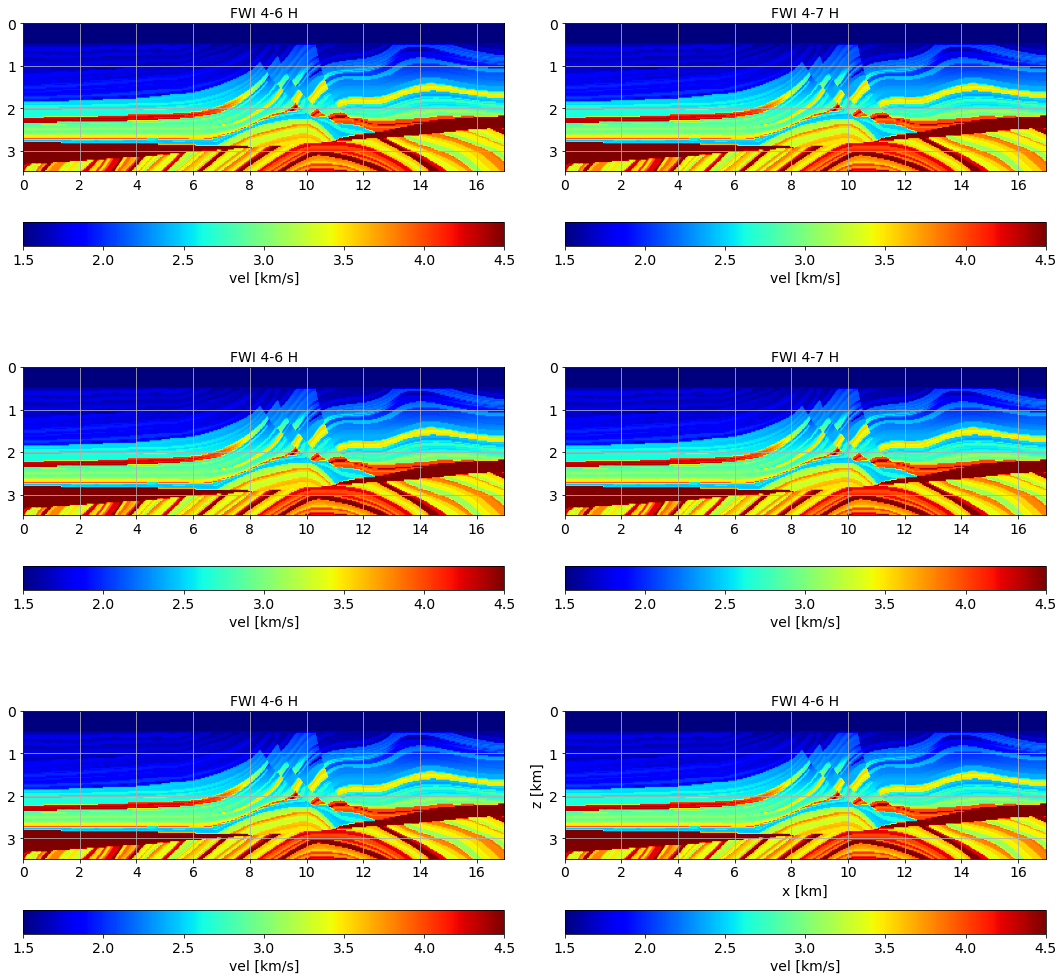

In [34]:
# Read inverted models

vel_true = genericIO.defaultIO.getVector("vel/BP_Salt-trueVel.H")
vel_init = genericIO.defaultIO.getVector("vel/BP_Salt-initVel1.H")
model_fwi = genericIO.defaultIO.getVector("BP_Salt_inv_mod_2_3.H")
model_fwime_s1 = genericIO.defaultIO.getVector("vel/BP_Salt-fwime-inv-mod-spline1.H")
model_fwime_s2 = genericIO.defaultIO.getVector("vel/BP_Salt-fwime-inv-mod-spline2.H")
model_fwime_s3 = genericIO.defaultIO.getVector("vel/BP_Salt-fwime-inv-mod-spline3.H")
model_fwime_s4 = genericIO.defaultIO.getVector("vel/BP_Salt-fwime-inv-mod-spline4.H")
model_fwime_s5 = genericIO.defaultIO.getVector("vel/BP_Salt-fwime-inv-mod-spline5.H")
model_fwime_noSpline = genericIO.defaultIO.getVector("vel/BP_Salt-fwime-inv-mod-noSpline.H")

# Convert to numpy arrays
vel_true_nd = vel_true.getNdArray()
vel_init_nd = vel_init.getNdArray()
model_fwi_nd = model_fwi.getNdArray()
model_fwime_s1_nd = model_fwime_s1.getNdArray()
model_fwime_s2_nd = model_fwime_s2.getNdArray()
model_fwime_s3_nd = model_fwime_s3.getNdArray()
model_fwime_s4_nd = model_fwime_s4.getNdArray()
model_fwime_s5_nd = model_fwime_s5.getNdArray()
model_fwime_noSpline_nd = model_fwime_noSpline.getNdArray()

fig, axs = plt.subplots(3, 2, figsize=(15, 15))

# Plot true velocity model
img0_0 = axs[0,0].imshow(vel_init_nd.T,cmap='jet', vmin=vel_true_nd.min(), vmax=vel_true_nd.max(), extent=(ox, (ox+(nx-1)*dx), (oz+(nz-1)*dz), oz), aspect=1.5)
axs[0,0].set_title("Initial model"), plt.xlabel("x [km]"), plt.ylabel("z [km]")
fig.colorbar(img0_0, ax=axs[0,0], orientation="horizontal", label="vel [km/s]")
axs[0,0].grid()
# plt.show()

# Plot initial velocity model
img0_1 = axs[0,1].imshow(model_fwi_nd.T,cmap='jet', vmin=vel_true_nd.min(), vmax=vel_true_nd.max(), extent=(ox, (ox+(nx-1)*dx), (oz+(nz-1)*dz), oz), aspect=1.5)
axs[0,1].set_title("FWI 4-13 Hz"), plt.xlabel("x [km]"), plt.ylabel("z [km]")
fig.colorbar(img0_1, ax=axs[0,1], orientation="horizontal", label="vel [km/s]")
axs[0,1].grid()
# plt.show()

# Plot true velocity model
img1_0 = axs[1,0].imshow(model_fwime_s1_nd.T,cmap='jet', vmin=vel_true_nd.min(), vmax=vel_true_nd.max(), extent=(ox, (ox+(nx-1)*dx), (oz+(nz-1)*dz), oz), aspect=1.5)
axs[1,0].set_title("FWIME spline 1"), plt.xlabel("x [km]"), plt.ylabel("z [km]")
fig.colorbar(img1_0, ax=axs[1,0], orientation="horizontal", label="vel [km/s]")
axs[1,0].grid()
# plt.show()

# Plot initial velocity model
img1_1 = axs[1,1].imshow(model_fwime_s2_nd.T,cmap='jet', vmin=vel_true_nd.min(), vmax=vel_true_nd.max(), extent=(ox, (ox+(nx-1)*dx), (oz+(nz-1)*dz), oz), aspect=1.5)
axs[1,1].set_title("FWIME spline 2"), plt.xlabel("x [km]"), plt.ylabel("z [km]")
fig.colorbar(img0_1, ax=axs[1,1], orientation="horizontal", label="vel [km/s]")
axs[1,1].grid()
# plt.show()

# Plot true velocity model
img2_0 = axs[2,0].imshow(model_fwime_noSpline.T,cmap='jet', vmin=vel_true_nd.min(), vmax=vel_true_nd.max(), extent=(ox, (ox+(nx-1)*dx), (oz+(nz-1)*dz), oz), aspect=1.5)
axs[2,0].set_title("FWIME FD grid"), plt.xlabel("x [km]"), plt.ylabel("z [km]")
fig.colorbar(img2_0, ax=axs[2,0], orientation="horizontal", label="vel [km/s]")
axs[2,0].grid()
# plt.show()

# Plot true velocity model
img2_1 = axs[2,1].imshow(vel_true_nd.T,cmap='jet', vmin=vel_true_nd.min(), vmax=vel_true_nd.max(), extent=(ox, (ox+(nx-1)*dx), (oz+(nz-1)*dz), oz), aspect=1.5)
axs[2,1].set_title("True velocity"), plt.xlabel("x [km]"), plt.ylabel("z [km]")
fig.colorbar(img2_1, ax=axs[2,1], orientation="horizontal", label="vel [km/s]")
axs[2,1].grid()
# plt.show()

plt.tight_layout()


## VI. References

* Billette, F., and S. Brandsberg-Dahl, 2005, The 2004 bp velocity benchmark: 67th EAGE Conference & Exhibition, European Association of Geoscientists & Engineers, cp–1.

* Barnier, G., E. Biondi, R. G. Clapp, and B. Biondi, 2022, Full waveform inversion by model extension: practical applications (manuscript submitted to Geophysics)